# Kalman Theory


## Multivariate notations

variables: 
* $\mathbf x$, $\mathbf P$: the state and covariance
* $\mathbf F$,  $\mathbf Q$: the process model and noise covariance
* $\mathbf{B,u}$: Optionally, the control input and function
* $\mathbf z$, the measurement mean, and $\mathbf R$, the measurement covariance.
* $\mathbf H$ measurment function
$$
* 

\begin{aligned}
\text{Predict Step}\\
\mathbf{\bar x} &= \mathbf{F x} + \mathbf{B u} \\
\mathbf{\bar P} &= \mathbf{FP{F}}^\mathsf T + \mathbf Q \\
\\
\text{Update Step}\\
\textbf{S} &= \mathbf{H\bar PH}^\mathsf T + \mathbf R \\
\mathbf K &= \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1} \\
\textbf{y} &= \mathbf z - \mathbf{H \bar x} \\
\mathbf x &=\mathbf{\bar x} +\mathbf{K\textbf{y}} \\
\mathbf P &= (\mathbf{I}-\mathbf{KH})\mathbf{\bar P}
\end{aligned}

$$

as seen in litrature:

 $$
\begin{aligned}
\hat{\mathbf x}_{k\mid k-1} &= \mathbf F_k\hat{\mathbf x}_{k-1\mid k-1} + \mathbf B_k \mathbf u_k  \\
\mathbf P_{k\mid k-1} &=  \mathbf F_k \mathbf P_{k-1\mid k-1} \mathbf F_k^\mathsf T + \mathbf Q_k \\        	
\tilde{\mathbf y}_k &= \mathbf z_k - \mathbf H_k\hat{\mathbf x}_{k\mid k-1}\\
\mathbf{S}_k &= \mathbf H_k \mathbf P_{k\mid k-1} \mathbf H_k^\mathsf T + \mathbf R_k \\
\mathbf K_k &= \mathbf P_{k\mid k-1}\mathbf H_k^\mathsf T \mathbf{S}_k^{-1}\\
\hat{\mathbf x}_{k\mid k} &= \hat{\mathbf x}_{k\mid k-1} + \mathbf K_k\tilde{\mathbf y}_k\\
\mathbf P_{k|k} &= (I - \mathbf K_k \mathbf H_k) \mathbf P_{k|k-1}
\\\end{aligned}
$$

# Kalman implementation 
## auxiliary functions


In [3]:
from numpy.random import randn
import math
def compute_dog_data(z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x, vel = 0., 1.
    z_std = math.sqrt(z_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)
        x += v*dt        
        xs.append(x)
        zs.append(x + randn() * z_std)        
    return np.array(xs), np.array(zs)


## Parameters

In [4]:
import numpy as np
from filterpy.common import Q_discrete_white_noise

# model data
dt = 1.
R_var = 10
Q_var = 0.01
F = np.array([[1, dt],
              [0,  1]])

R = np.array([[R_var]])
Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_var)
H = np.array([[1., 0.]])

# initial data 
x = np.array([[10.0, 4.5]]).T
P = np.diag([500, 49])

#creating data
count = 50
track, zs = compute_dog_data(R_var, Q_var, count,dt=dt)

## fitlterPy implementaion

In [5]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Saver
def pos_vel_filter(x, P, R, Q=0., dt=1.0):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([x[0], x[1]]) # location and velocity
    kf.F = np.array([[1., dt],
                     [0.,  1.]])  # state transition matrix
    kf.H = np.array([[1., 0]])    # Measurement function
    kf.R *= R                     # measurement uncertainty
    if np.isscalar(P):
        kf.P *= P                 # covariance matrix 
    else:
        kf.P[:] = P               # [:] makes deep copy
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)
    else:
        kf.Q[:] = Q
    return kf


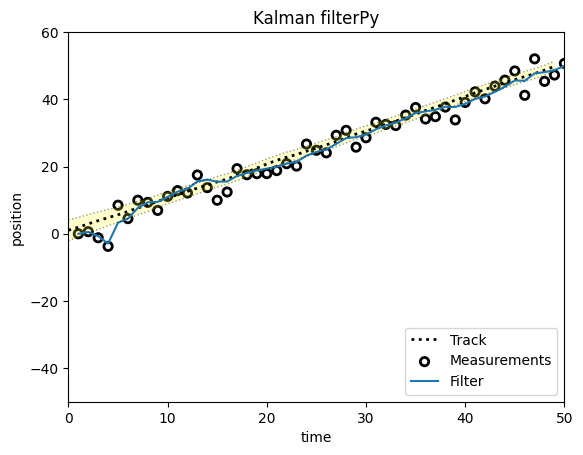

In [6]:
from kf_book.mkf_internal import plot_track

kf = pos_vel_filter([0, .1], R=R, P=P, Q=Q, dt=1.) 
s = Saver(kf)
for z in zs:
    kf.predict()
    kf.update(z)
    s.save()  # save the current state

# print(s.keys)
s.to_array()
plot_track(s.x[:, 0], track, s.z, s.P,plot_P=False,title="Kalman filterPy")


## self implemenation

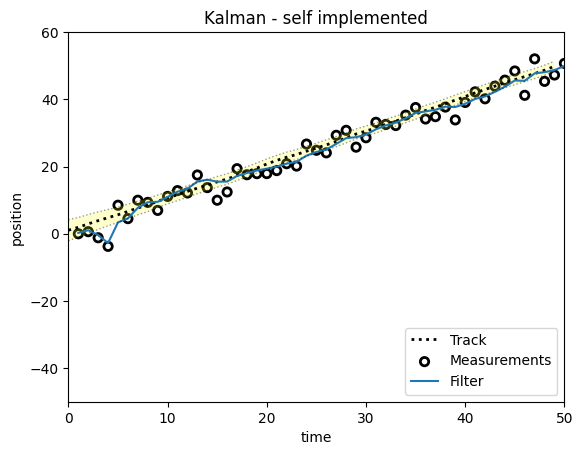

In [7]:


from scipy.linalg import inv


xs, cov = [], []
for z in zs:
    # predict
    x = F @ x
    P = F @ P @ F.T + Q
    
    #update
    S = H @ P @ H.T + R
    K = P @ H.T @ inv(S)
    y = z - H @ x
    x += K @ y
    P = P - K @ H @ P
    
    xs.append(x)
    cov.append(P)

xs, cov = np.array(xs), np.array(cov)
plot_track(xs[:, 0], track, zs, cov, plot_P=False, title="Kalman - self implemented")

In [8]:

#paper parameters
#derived from data
expectation_x0 = -3.155211e-02
expectation_P = np.array([[0.180368 ,0],
                         [0 ,0.175440]])
cov_vk = np.array([[0 ,0], # Q_discrete_white_noise(dim=2, dt=dt, var=Q_var)
                  [0 ,0]])

expectation_wk2 = 0
 
gamma0 = 0
omega0 = 0
fs = 1
Ts = 1/fs
wk = math.sqrt(omega0**2 - (gamma0**2/4))


# F matrix
F11 = (gamma0 * math.sin(wk * Ts) / (2 * wk)) + math.cos(wk * Ts)
F12 = (1 / wk) * math.sin(wk * Ts)

F21 = -((gamma0**2 / (4 * wk)) + wk) * math.sin(wk * Ts)
F22 = F11




#model data
dt = 1.
R_var = expectation_wk2
Q_var = 0 # ????? its matrix, this value its only to create dog data

F = np.array([[F11, F12],
               [F21, F22]])

R = np.array([[R_var]])
Q = cov_vk
H = np.array([[1., 0.]])

# initial data 
x = expectation_x0 
P = expectation_P[:]

#creating data
count = 50
track, zs = compute_dog_data(R_var, Q_var, count,dt=dt)

ZeroDivisionError: float division by zero